In [13]:
import pandas as pd
import os

In [14]:
import random
import matplotlib.pyplot as plt
import collections
import numpy as np
import operator
import simpleclock
import sklearn.metrics

In [15]:
import torch
import torchtext

## Dataset, iterators

In [16]:
data_path = os.path.join(os.path.abspath(''), "data_cine_cleaned.csv")

In [17]:
TEXT = torchtext.data.Field(tokenize = "spacy",
                            tokenizer_language="fr_core_news_sm",
                            include_lengths=True)
LABEL = torchtext.data.LabelField(dtype=torch.float, use_vocab=False)

In [18]:
dataset = torchtext.data.TabularDataset(path=data_path,
                                        format="CSV",
                                        fields={"critique": ("critique", TEXT), "note": ("note", LABEL)})

In [19]:
data_train, data_test = dataset.split()

In [20]:
data_train, data_valid = data_train.split()

In [21]:
print(f"""training data: {len(data_train)} examples.
validation data: {len(data_valid)} examples.
test data: {len(data_test)} examples.""")

training data: 36057 examples.
validation data: 15453 examples.
test data: 22076 examples.


In [22]:
vectors = torchtext.vocab.Vectors("cc.fr.300.vec", os.path.join(os.path.expanduser("~"), "Downloads"))

In [23]:
VOCAB_MAX_SIZE = 50000
TEXT.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=vectors)

In [62]:
DEVICE = torch.device("cuda")

In [25]:
BATCH_SIZE = 512

In [26]:
iter_train, iter_valid, iter_test = \
    torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                         batch_size=BATCH_SIZE,
                                         device=device,
                                         sort_within_batch=True,
                                         sort_key=lambda example: len(example.critique),
                                         sort=False)

## Model definition and training

In [27]:
class RNN(torch.nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_dim, output_dim, dropout, pad_idx):
        super().__init__()
        bidirectional = True
        num_dir = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(n_vocab, embedding_dim, padding_idx = pad_idx)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 bidirectional=bidirectional,
                                 num_layers=3)
        self.fc = torch.nn.Linear(hidden_dim * num_dir, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input, lengths):
        torch.nn.utils.rnn.pack_padded_sequence(input, lengths)
        embedded = self.embedding(input)  # ((sent_len, batch_size), emb_dim)
        packed_output, (hidden, cell) = self.rnn(embedded)  # hidden: (num_layers * num_directions, batch, hidden_size)
        return self.sigmoid(self.fc(self.dropout(
            torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1).squeeze(0))))  # (batch_size, 1)

In [103]:
N_VOCAB = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model = RNN(N_VOCAB, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, dropout=DROPOUT, pad_idx=PAD_IDX)

In [29]:
def pseudo_init(model, criterion, device=device, learn_embedding_param=True):
    model.embedding.weight.data.copy_(TEXT.vocab.vectors)
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    
    for name, param in model.named_parameters():
        if name == "embedding.weight":
            param.requires_grad = learn_embedding_param
    print("The model has {:,} trainable parameters"
         .format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    return model, criterion

In [30]:
# model, criterion = pseudo_init(model, torch.nn.MSELoss(), learn_embedding_param=False)
# optimizer = torch.optim.Adam(model.parameters())

In [31]:
def output_to_pred(output):
    return (output * 10).round() / 2

In [32]:
def accuracy(preds, y):
    correct = (preds == y).float()# convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [33]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        padded_sequences, lengths = batch.critique
        output = model(padded_sequences, lengths).squeeze(1)
        loss = criterion(output, batch.note / 5.)
        acc = accuracy(output_to_pred(output), batch.note)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            padded_sequences, lengths = batch.critique
            output = model(padded_sequences, lengths).squeeze(1)
            loss = criterion(output, batch.note / 5.)
            acc = accuracy(output_to_pred(output), batch.note)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [195]:
class TrainInfo:
    def __init__(self, valid={}, train={}):
        self.valid = collections.defaultdict(lambda: [])
        self.valid.update(valid)
        self.train = collections.defaultdict(lambda: [])
        self.train.update(train)
    
    def save(self, path):
        packed = {
            "valid": dict(self.valid),
            "train": dict(self.train),
        }
        with open(path, "wb") as f:
            pickle.dump(packed, f)
    
    @classmethod
    def load(cls, path):
        with open(path, "rb") as f:
            packed = pickle.load(f)
            return cls(valid=packed["valid"],
                       train=packed["train"])
    
    @staticmethod
    def _dict_to_repr(d):
        return dict(map(lambda k_v: (k_v[0], f"{len(k_v[1])} elements"), d.items()))
    
    def __repr__(self):
        return pprint.pformat({"valid": self._dict_to_repr(self.valid),
                     "train": self._dict_to_repr(self.train),})

In [210]:
t = TrainInfo()
t.valid["coincoin"] = list(range(43, 56))
t.valid[1] = [0, 1, 2, 3]
t.valid[2] = [2, 34]

False

In [81]:
def do_training(model, name, iter_train, iter_valid, optimizer, criterion, fun_train,
                fun_eval, n_epochs=100, best_valid_loss=float('inf')):

    clock = simpleclock.Clock.started()
    torch.cuda.empty_cache()
    train_info = TrainInfo()
    
    for epoch in range(n_epochs):

        clock.elapsed_since_start.call()  # meh

        train_loss, train_acc = fun_train(model, iter_train, optimizer, criterion)
        valid_loss, valid_acc = fun_eval(model, iter_valid, criterion)

        clock.elapsed_since_last_call.print(f"Epoch: {epoch+1:02} | Epoch Time")
        train_info.train["loss"].append(train_loss)
        train_info.valid["loss"].append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"best_model_{name}.pt")

    clock.elapsed_since_start.print("Total time")
    return train_info

In [98]:
class TrainSet:
    def __init__(self, model, name, iter_train, iter_valid,
                 fun_optimizer, fun_criterion, fun_train, fun_eval,
                 device=DEVICE, n_epochs=100):
        self.model = model
        self.name = name
        self.iter_train = iter_train
        self.iter_valid = iter_valid
        self.fun_optimizer = fun_optimizer
        self.optimizer = None
        self.fun_criterion = fun_criterion
        self.criterion = None
        self.fun_train = fun_train
        self.fun_eval = fun_eval
        self.n_epochs = n_epochs
        self.device = device
    
    def init(self, learn_embedding_param=True):
        self.model, self.criterion = pseudo_init(self.model, self.fun_criterion(), self.device,
                                                 learn_embedding_param=learn_embedding_param)
        self.optimizer = self.fun_optimizer(self.model.parameters())
    
    def do_training(self):
        return do_training(model=self.model,
                           name=self.name,
                           iter_train=self.iter_train,
                           iter_valid=self.iter_valid,
                           optimizer=self.optimizer,
                           criterion=self.criterion,
                           fun_train=self.fun_train,
                           fun_eval=self.fun_eval,
                           n_epochs=self.n_epochs)

In [100]:
train_sets = []

for hidden_dim in [128, 256, 512]:
    train_sets.append(TrainSet(
        model=RNN(N_VOCAB, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, dropout=DROPOUT, pad_idx=PAD_IDX),
        name=f"rnn_hidden-{hidden_dim}",
        iter_train=iter_train,
        iter_valid=iter_valid,
        fun_optimizer=torch.optim.Adam,
        fun_criterion=torch.nn.MSELoss,
        fun_train=train,
        fun_eval=evaluate,
        n_epochs=50
    ))

The model has 19,297,817 trainable parameters
Epoch: 01 | Epoch Time: 10.28s
Epoch: 02 | Epoch Time: 10.31s
Epoch: 03 | Epoch Time: 10.30s
Epoch: 04 | Epoch Time: 10.33s
Epoch: 05 | Epoch Time: 10.31s
Epoch: 06 | Epoch Time: 10.35s
Epoch: 07 | Epoch Time: 10.27s
Epoch: 08 | Epoch Time: 10.26s
Epoch: 09 | Epoch Time: 10.33s
Epoch: 10 | Epoch Time: 10.31s
Epoch: 11 | Epoch Time: 10.35s
Epoch: 12 | Epoch Time: 10.38s
Epoch: 13 | Epoch Time: 10.41s
Epoch: 14 | Epoch Time: 10.34s
Epoch: 15 | Epoch Time: 10.36s
Epoch: 16 | Epoch Time: 10.36s
Epoch: 17 | Epoch Time: 10.38s
Epoch: 18 | Epoch Time: 10.39s
Epoch: 19 | Epoch Time: 10.36s
Epoch: 20 | Epoch Time: 10.38s
Epoch: 21 | Epoch Time: 10.38s
Epoch: 22 | Epoch Time: 10.36s
Epoch: 23 | Epoch Time: 10.37s
Epoch: 24 | Epoch Time: 10.35s
Epoch: 25 | Epoch Time: 10.34s
Epoch: 26 | Epoch Time: 10.42s
Epoch: 27 | Epoch Time: 10.42s
Epoch: 28 | Epoch Time: 10.76s
Epoch: 29 | Epoch Time: 10.38s
Epoch: 30 | Epoch Time: 10.39s
Epoch: 31 | Epoch Time: 

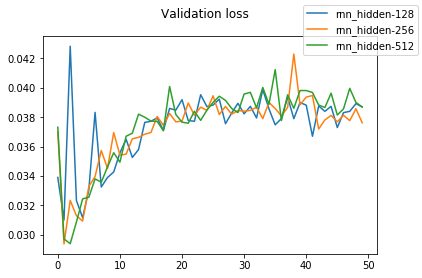

In [102]:
fig, ax = plt.subplots()
for train_set in train_sets:
    train_set.init()
    train_info = train_set.do_training()
    
    #ax_train = ax.plot(list(range(train_set.n_epochs)), train_info.train["loss"], label="train")
    ax_valid = ax.plot(list(range(train_set.n_epochs)), train_info.valid["loss"],
                       label=f"{train_set.name}")
fig.legend()
fig.suptitle("Validation loss")
plt.savefig(f"loss_valid.png")

## Peeking

In [108]:
import spacy

nlp = spacy.load('fr_core_news_sm')

In [106]:
def predict_tokens(tokens, model):
    model.eval()
    idxs = [TEXT.vocab.stoi[t] for t in tokens]
    inp = torch.LongTensor(idxs).reshape(-1, 1).to(device)
    output = output_to_pred(model(inp, torch.LongTensor([len(tokens)])))
    return output.item()


def predict(sentence, model):
    return predict_tokens(list(map(str, nlp.tokenizer(sentence))), model)

In [104]:
model.load_state_dict(torch.load('best_model_rnn_hidden-512.pt'))

<All keys matched successfully>

In [110]:
model = model.to(DEVICE)

In [112]:
predict("Du temps perdu.", model), \
predict("Un très bon film, à voir avec toute la famille.", model)

(2.5, 4.0)

In [113]:
for example in random.sample(list(data_test), 3):
    tokens, note = example.critique, float(example.note)
    print(" ".join(tokens))
    print(f"true) {note} - {predict_tokens(tokens, model)} (pred")

Bouleversant , parfois dérangeant . Inoubliable , en tout cas .
true) 4.0 - 4.0 (pred
On attendait ce volume 3 avec impatience et on n' est pas déçu . Les petits se gondolent , les plus grands aussi .
true) 3.0 - 3.5 (pred
Malgré un scénario faiblard et une longueur éprouvante , " Transformers 4 : L' Âge de l' extinction " ne s' en sort pas trop mal grâce au renouveau du casting , l' introduction des Dinobots , et l' ahurissante mise en scène du maître artificier Michael Bay .
true) 3.0 - 1.5 (pred


## Testing predictions on extremal marks

Is the model really doing bad if it predicts a 4.5 instead of a 5 ? There are at least two ways to allow for forgivable divergence with the test data :
* decrease notation's granularity, e.g. tranform the marks into good/bad, or good/bad/neutral.
* consider a prediction correct if it belongs to a 'small' interval containing the true value.

### Good/Neutral/Bad prediction

In [114]:
def mark_to_3_way(mark_tensor, bad_treshold=2, good_treshold=3.5):
    """np array with values: 0: bad, 1: neutral, 2: good"""
    return np.digitize(mark_tensor.cpu().detach().numpy(), [bad_treshold, good_treshold])

def pred_to_3_way(pred_tensor, bad_treshold=0.4, good_treshold=0.651):
    """np array with values: 0: bad, 1: neutral, 2: good"""
    return np.digitize(pred_tensor.cpu().detach().numpy(), [bad_treshold, good_treshold])
    
def eval_accuracy_3w(model, iterator):
    n_examples = 0
    n_success = 0
    for batch in iterator:
        padded_sequences, lengths = batch.critique
        predictions = model(padded_sequences, lengths).squeeze(1)
        n_examples += len(batch)
        n_success += sum(pred_to_3_way(predictions) == mark_to_3_way(batch.note))
    return n_success / n_examples

def classif_report_3w(model, iterator):
    def preds_and_trues_to_array(predictions, true_notes):
        return np.concatenate([mark_to_3_way(true_notes).reshape(-1, 1),
                               pred_to_3_way(predictions).reshape(-1, 1)], axis=1)
    
    array = None
    for batch in iterator:
        padded_sequences, lengths = batch.critique
        predictions = model(padded_sequences, lengths).squeeze(1)
        
        if array is None:
            array = preds_and_trues_to_array(predictions, batch.note)
        else:
            array = np.concatenate([array,
                                    preds_and_trues_to_array(predictions, batch.note)], axis=0)
    print(sklearn.metrics.classification_report(array[:, 0],
                                                array[:, 1],
                                                labels=[0, 1, 2],
                                                target_names=["bad", "neutral", "good"]))

In [115]:
iterator = iter_test

classif_report_3w(model, iterator)


              precision    recall  f1-score   support

         bad       0.30      0.48      0.37      1688
     neutral       0.65      0.48      0.55      9696
        good       0.72      0.82      0.77     10692

    accuracy                           0.65     22076
   macro avg       0.56      0.59      0.56     22076
weighted avg       0.66      0.65      0.64     22076



### Fuzzy accuracy

In [116]:
def eval_accuracy_fuzzy(model, iterator, fuzziness=.5):
    n_examples = 0.
    n_success = 0.
    for batch in iterator:
        padded_sequences, lengths = batch.critique
        predictions = model(padded_sequences, lengths).squeeze(1)
        n_examples += len(batch)
        n_success += sum(torch.abs(output_to_pred(predictions) - batch.note) <= fuzziness).item()
    return n_success / n_examples

In [188]:
eval_accuracy_fuzzy(model, iter_test, fuzziness=.5)